In [1]:
# import relevant libraries

# basic libraries
import pandas as pd
import numpy as np
from collections import Counter
import re

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries
from sklearn import tree, metrics, model_selection, linear_model, ensemble, preprocessing, feature_extraction, feature_selection

# data collection libraries
import requests
from selenium import webdriver
import bs4
import imdbpie
import json

%matplotlib inline

# Identify: Problem Statement & Goals

**Using data from IMDB, can we build a model that predicts movie ratings based on certain inputs?**

- Predict movie ratings using information about the movie (e.g. genre, length of movie etc.)
- What are the factors that affect movie rating?

# Acquire: Query IMDB, write results, scrape IMDB

## Basic information using OMDBAPI, requests and BeautifulSoup

In [11]:
r2 = requests.get("http://www.imdb.com/chart/top")
soup = bs4.BeautifulSoup(r2.content, "lxml")
id_list = re.findall("tt[0-9]{7,8}", r2.content)
id_list = list(set(id_list))

In [12]:
id_list[:5]

['tt2582802', 'tt0047478', 'tt0082971', 'tt0050212', 'tt0848228']

In [13]:
len(id_list)

250

In [31]:
# Getting more IDs
low_ratings = 'http://www.imdb.com/search/title?genres={}&title_type=feature&sort=user_rating,asc&page={}&ref_=adv_nxt'
high_ratings = 'http://www.imdb.com/search/title?genres={}&title_type=feature&sort=user_rating,desc&page={}&ref_=adv_nxt'
high_num = 'http://www.imdb.com/search/title?genres={}&title_type=feature&sort=num_votes,desc&page={}&ref_=adv_nxt'
low_num = 'http://www.imdb.com/search/title?genres={}&title_type=feature&sort=num_votes,asc&page={}&ref_=adv_nxt'

# path to phantomjs
phan_path = '//Applications/phantomjs'

# function to get list of genres from IMDB
def get_genre_list():
    r = requests.get("http://www.imdb.com/genre/")
    soup = bs4.BeautifulSoup(r.text, "lxml")
    genre_list = []
    for i in soup.findAll('a'):
        try:
            if 'genre/' in i['href'] and 'genre/?' not in i['href'] and i.find('span'):
                genre_list.append(i.text.split()[0])
        except:
            pass
    return genre_list

# function to get a list of IDs from each genre
def get_id(genre, target_url,page):
    r = requests.get(target_url.format(genre, page))
    soup = bs4.BeautifulSoup(r.text, "lxml")
    ids = []
    count = 5
    ids = re.findall("tt[0-9]{7,8}", soup.prettify())
    ids = list(set(ids))
#     for i in soup.findAll('a'):
#         try:
#             if count > 0 and 'title/tt' in i['href'] and 'http' not in i['href']:
# #                 print i
#                 try:
#                     for j in i['href'].split('/'):
#                         if 'tt' in j and '_' not in j:
#                             ids.append(j.strip())
#                     count -= 1
#                 except:
#                     pass
#         except:
#             pass
    return ids[:5]

In [32]:
# variables
all_genres = []
all_ids = []
url_list = [low_ratings, high_ratings, high_num, low_num]

In [33]:
all_genres = get_genre_list()

In [34]:
for i in all_genres:
    print i, 
    for x,j in enumerate(url_list):
        for k in [1,15]:
            id_l = get_id(i,j,k)
#             print len(id_l),
            all_ids.extend(id_l)

Action Adventure Animation Biography Comedy Crime Documentary Drama Family Fantasy Film-Noir History Horror Music Musical Mystery Romance Sci-Fi Sport Thriller War Western


In [37]:
extra_ids = id_list + all_ids
extra_ids = list(set(extra_ids))
len(extra_ids)

947

In [38]:
# OMDB API URL
api_url = "http://www.omdbapi.com/?i={}&plot=full&r=json"

In [39]:
# path to phantomjs
phan_path = "//Applications/phantomjs"

In [40]:
def get_content(id_num):
    r = requests.get(api_url.format(id_num))
#     tmp = pd.DataFrame(json.loads(r.text), index=[0])
    tmp = json.loads(r.text)
    return tmp

In [44]:
df = pd.DataFrame([get_content(i) for i in extra_ids])

In [45]:
df.head()

,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,Poster,...,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,NaN,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,...,15 Oct 2014,True,107 min,Whiplash,movie,Damien Chazelle,2014,tt2582802,8.5,"413,720"
1,"Liam Card, Ana Candia, Eva Redpath, David Bajurny",N/A,Canada,Alberto Diamante,NaN,"Comedy, Music, Romance",English,N/A,A corpse lies on a living room floor. Our lead...,http://ia.media-imdb.com/images/M/MV5BMjEwMzA0...,...,14 Oct 2011,True,90 min,Love... and Other Reasons to Panic,movie,Alberto Diamante,2007,tt0979965,7.9,47
2,"Gheorghe Cozorici, Sergiu Nicolaescu, Mircea A...",1 nomination.,"Romania, East Germany",Sergiu Nicolaescu,NaN,"Adventure, Drama, War",Romanian,N/A,In 1918 a defeated Austro-Hungarian Baron Colo...,http://ia.media-imdb.com/images/M/MV5BMjYxYWM2...,...,26 Jan 1981,True,111 min,Mercenaries' Trap,movie,"Liviu Gheorghiu (screenplay), Sergiu Nicolaesc...",1981,tt0080494,7.5,278
3,"Ky Baldwin, Dylan Elchaar, Kate Fitzpatrick, M...",N/A,N/A,N/A,NaN,Animation,N/A,N/A,Autumn is here and it's time for a change. In ...,http://ia.media-imdb.com/images/M/MV5BMTAyMDQw...,...,01 Sep 2014,True,72 min,Guess How Much I Love You: Autumn's Here,movie,N/A,2014,tt4061854,8.2,5
4,"Luis Aguilar, Julio Aldama, Roberto Cañedo, No...",N/A,Mexico,Rafael Baledón,NaN,"Adventure, Drama, Western",Spanish,N/A,N/A,N/A,...,12 Aug 1965,True,85 min,El tigre de Guanajuato: Leyenda de venganza,movie,José María Fernández Unsáin (story),1965,tt0281286,4.4,5


In [46]:
df.shape

(947, 21)

In [47]:
df.to_csv("imdb_extra_id.csv", encoding="utf-8")

## Add gross revenue

In [48]:
def get_gross(id_num):
    r = requests.get("http://www.imdb.com/title/{}/".format(id_num))
    soup = bs4.BeautifulSoup(r.text, "lxml")
    try:
        for i in soup.findAll("div", class_="txt-block"):
            for j in i.findAll("h4", class_="inline"):
                if "Gross" in j.text:
                    text = j.parent.text.split()[1]
                    num = text.replace(",", "").strip("$")
                    return float(num)
    except:
        return 0

In [ ]:
df["Gross_earnings"] = df["imdbID"].map(get_gross)

In [26]:
df = df.replace("", np.nan)
df = df.replace("N/A", np.nan)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 21 columns):
Actors            250 non-null object
Awards            246 non-null object
Country           250 non-null object
Director          250 non-null object
Genre             250 non-null object
Language          249 non-null object
Metascore         169 non-null object
Plot              250 non-null object
Poster            248 non-null object
Rated             249 non-null object
Released          249 non-null object
Response          250 non-null object
Runtime           250 non-null object
Title             250 non-null object
Type              250 non-null object
Writer            250 non-null object
Year              250 non-null object
imdbID            250 non-null object
imdbRating        250 non-null object
imdbVotes         250 non-null object
Gross_earnings    184 non-null float64
dtypes: float64(1), object(20)
memory usage: 41.1+ KB


In [30]:
df.to_csv("imdb_scraped.csv", encoding="utf-8")

# Mine: Rename & describe data

In [102]:
df2 = df.copy()

In [103]:
df2["Date"] = pd.to_datetime(df2["Released"])

In [104]:
df2.Title[df2.Date.isnull()]

73    The Gold Rush
Name: Title, dtype: object

In [105]:
df2.set_value(df2.Date.isnull(), "Released","26 June 1925");
df2.set_value(df2["Title"] == "The Gold Rush", "Date", pd.to_datetime(df2["Released"][df2["Title"] == "The Gold Rush"]));

In [106]:
df2["Runtime_min"] = df2["Runtime"].map(lambda x: float(x.split()[0]))

In [107]:
df2["Year"] = df2["Year"].astype(int)

In [108]:
df2["Month"] = df2["Date"].map(lambda x: x.month)

In [109]:
df2["imdbRating"] = df2["imdbRating"].astype(float)

In [110]:
df2["imdbVotes"] = df2["imdbVotes"].map(lambda x: float(x.replace(",", "")))

In [161]:
def oscars_won(i):
    try:
        i_list = i.split()
        if "Oscars." in i.split() and i_list[i_list.index("Oscars.")-2] == "Won":
            return float(i_list[i_list.index("Oscars.")-1])
        else:
            return 0
    except:
        return 0

In [162]:
df2["Oscars_won"] = df2["Awards"].map(oscars_won)

In [163]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Genre_Drama,Genre_ Sport,Genre_ Biography,Genre_ Fantasy,Genre_ Crime,Genre_ Music,Genre_ Comedy,Genre_ War,Genre_Biography,Genre_ Romance
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,...,1,0,0,0,0,1,0,0,0,0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",https://images-na.ssl-images-amazon.com/images...,UNRATED,...,1,0,0,0,0,0,0,0,0,0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,https://images-na.ssl-images-amazon.com/images...,PG,...,0,0,0,0,0,0,0,0,0,0
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",0,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,...,1,0,0,0,0,0,0,1,0,0
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Nominated for 1 Oscar. Another 34 wins & 75 no...,USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",69,"Nick Fury is the director of S.H.I.E.L.D., an ...",https://images-na.ssl-images-amazon.com/images...,PG-13,...,0,0,0,0,0,0,0,0,0,0


In [164]:
# Let"s consider the language the movie is available in
# For model simplicity, we'll consider just the top 5 languages
all_languages = []
for i in df2["Language"]:
    lang_list = str(i).split(",")
    all_languages.extend([j.strip() for j in lang_list])
top_5_languages = [i[0] for i in Counter(all_languages).most_common(5)]
top_5_languages

['English', 'French', 'German', 'Spanish', 'Italian']

In [165]:
for i in top_5_languages:
    df2["Language_"+i] = df2["Language"].map(lambda x: 1 if i in str(x) else 0)
# df2["Language_English"] = df2["Language"].map(lambda x: 1 if "English" in str(x) else 0)

In [166]:
country = []
for i in df2["Country"]:
    country.extend(i.split(","))
country_counts = Counter(country)

In [167]:
# Let"s consider where the movies are made
# For model simplicity, we'll consider just the top 5 countries
top_5_countries = [i[0] for i in country_counts.most_common(5)]
top_5_countries

[u'USA', u' UK', u' USA', u'UK', u'Japan']

In [168]:
for i in top_5_countries:
    df2["Country_"+i] = df2["Country"].map(lambda x: 1 if i in str(x) else 0)

In [169]:
df2["Rated"].value_counts()

R            106
PG            37
PG-13         33
NOT RATED     28
APPROVED      18
G             13
UNRATED        9
PASSED         4
M              1
Name: Rated, dtype: int64

In [170]:
def group_rating(rate):
    if rate in ["R", "PG", "PG-13", "G"]:
        return rate
    else:
        return "OTHER"

In [171]:
df2["Rate_clean"] = df2["Rated"].map(group_rating)

In [172]:
rate_dummies = pd.get_dummies(df2["Rate_clean"])
rate_dummies = rate_dummies.drop("OTHER", axis=1)

In [173]:
df2 = pd.concat([df2, rate_dummies], axis=1)

In [174]:
# Get genre_dummies
genre_list = []
for i in df2["Genre"]:
    genre_list.extend(i.split(","))
genre_list = list(set(genre_list))

for i in genre_list:
    df2["Genre_"+i] = df2["Genre"].apply(lambda x: 1 if i in str(x) else 0)

In [175]:
df2["Type"].value_counts()

movie    250
Name: Type, dtype: int64

In [176]:
df2["Response"].value_counts()

True    250
Name: Response, dtype: int64

In [177]:
df2["Released"][:5]

0    15 Oct 2014
1    19 Nov 1956
2    12 Jun 1981
3    14 Dec 1957
4    04 May 2012
Name: Released, dtype: object

In [178]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Genre_ Crime,Genre_ Music,Genre_ Comedy,Genre_ War,Genre_Biography,Genre_ Romance,G,PG,PG-13,R
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,...,0,1,0,0,0,0,0,0,0,1
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",https://images-na.ssl-images-amazon.com/images...,UNRATED,...,0,0,0,0,0,0,0,0,0,0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,https://images-na.ssl-images-amazon.com/images...,PG,...,0,0,0,0,0,0,0,1,0,0
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",0,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,...,0,0,0,1,0,0,0,1,0,0
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Nominated for 1 Oscar. Another 34 wins & 75 no...,USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",69,"Nick Fury is the director of S.H.I.E.L.D., an ...",https://images-na.ssl-images-amazon.com/images...,PG-13,...,0,0,0,0,0,0,0,0,1,0


In [179]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 76 columns):
Actors              250 non-null object
Awards              246 non-null object
Country             250 non-null object
Director            250 non-null object
Genre               250 non-null object
Language            249 non-null object
Metascore           250 non-null object
Plot                250 non-null object
Poster              248 non-null object
Rated               249 non-null object
Released            250 non-null object
Response            250 non-null object
Runtime             250 non-null object
Title               250 non-null object
Type                250 non-null object
Writer              250 non-null object
Year                250 non-null int64
imdbID              250 non-null object
imdbRating          250 non-null float64
imdbVotes           250 non-null float64
Gross_earnings      250 non-null float64
Date                250 non-null datetime64[ns]
Runti

In [180]:
# To be able to use gross earnings in our model, 
# we'll assume that if the gross earnings information is not available, then the movie earned $0
df2["Gross_earnings"].fillna(0, inplace=True)

In [181]:
# Similarly for metascore
# we'll assume that it's 0 if the information is not available
df2["Metascore"].fillna(0, inplace=True)

In [182]:
df2.to_csv("imdb_clean.csv", encoding="utf-8")

# Refine: Visualize data
Bonus: Use multiple data viz tools

In [333]:
df3 = df2.copy()

In [334]:
for i in df3.columns.values:
    print '"'+i+'"'+",",

"Actors", "Awards", "Country", "Director", "Genre", "Language", "Metascore", "Plot", "Poster", "Rated", "Released", "Response", "Runtime", "Title", "Type", "Writer", "Year", "imdbID", "imdbRating", "imdbVotes", "Gross_earnings", "Date", "Runtime_min", "Month", "Oscars_won", "Language_English", "Language_French", "Language_German", "Language_Spanish", "Language_Italian", "Country_USA", "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", "Rate_clean", "G", "PG", "PG-13", "R", "Genre_Sci-Fi", "Genre_ Horror", "Genre_Crime", "Genre_Action", "Genre_Animation", "Genre_ Adventure", "Genre_ Western", "Genre_Comedy", "Genre_ Thriller", "Genre_ Sci-Fi", "Genre_Horror", "Genre_Film-Noir", "Genre_ Mystery", "Genre_ History", "Genre_ Musical", "Genre_ Drama", "Genre_Adventure", "Genre_ Action", "Genre_Western", "Genre_Mystery", "Genre_ Family", "Genre_ Film-Noir", "Genre_Drama", "Genre_ Sport", "Genre_ Biography", "Genre_ Fantasy", "Genre_ Crime", "Genre_ Music", "Genre_ Comedy", "Genre_ 

In [349]:
rel_columns = ["imdbRating", "imdbID", "Title", 
               "Writer", "Actors", "Director", "Plot","Metascore", 
               "Year", "Month", "imdbVotes", "Gross_earnings", 
               "Runtime_min", "Oscars_won", 
               "Language_English", "Language_French", "Language_German", 
               "Language_Spanish", "Language_Italian", 
               "Country_USA", "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", 
               "G", "PG", "PG-13", "R", 
               "Genre_Sci-Fi", "Genre_ Horror", "Genre_Crime", "Genre_Action", 
               "Genre_Animation", "Genre_ Adventure", "Genre_ Western", "Genre_Comedy", 
               "Genre_ Thriller", "Genre_ Sci-Fi", "Genre_Horror", "Genre_Film-Noir", 
               "Genre_ Mystery", "Genre_ History", "Genre_ Musical", "Genre_ Drama", 
               "Genre_Adventure", "Genre_ Action", "Genre_Western", "Genre_Mystery", 
               "Genre_ Family", "Genre_ Film-Noir", "Genre_Drama", "Genre_ Sport", 
               "Genre_ Biography", "Genre_ Fantasy", "Genre_ Crime", "Genre_ Music", 
               "Genre_ Comedy", "Genre_ War", "Genre_Biography", "Genre_ Romance"]
num_cat_features = rel_columns[7:]


In [350]:
df3 = df3[rel_columns]

In [351]:
# Scale our continuous colums
# We'll consider year and month as continuous for this
scale_columns = ["Metascore", "Year", "Month", "imdbVotes", "Gross_earnings", "Runtime_min", "Oscars_won"]
scaler = preprocessing.StandardScaler()
scaler.fit(df3[scale_columns])

for i,j in enumerate(scale_columns):
    df3[j] = scaler.transform(df3[scale_columns])[:,i]

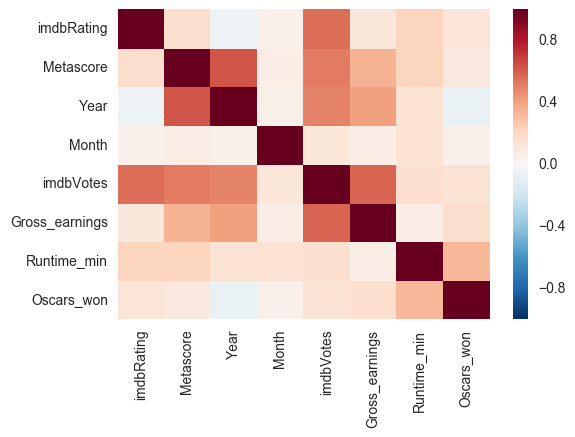

In [352]:
sns.heatmap(df3.iloc[:,:14].corr());

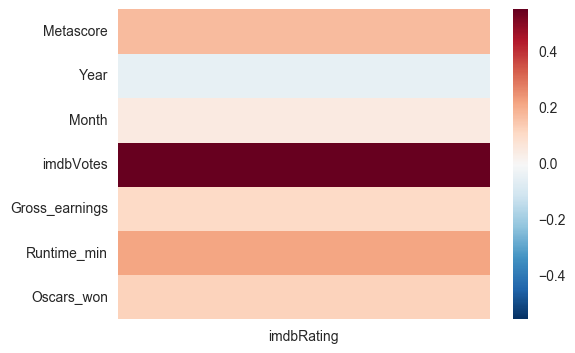

In [353]:
sns.heatmap(df3.iloc[:,:14].corr()[["imdbRating"]].iloc[1:]);

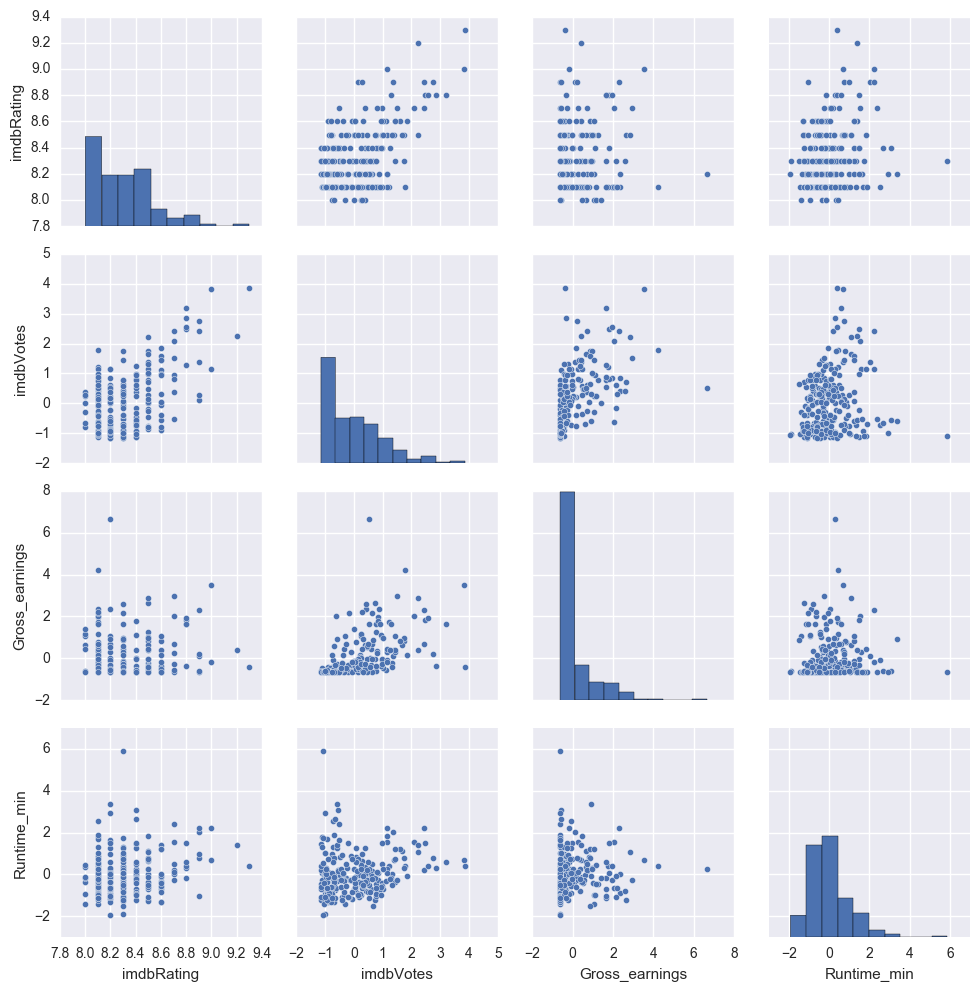

In [354]:
sns.pairplot(df3[["imdbRating", "imdbVotes", "Gross_earnings", "Runtime_min"]]);

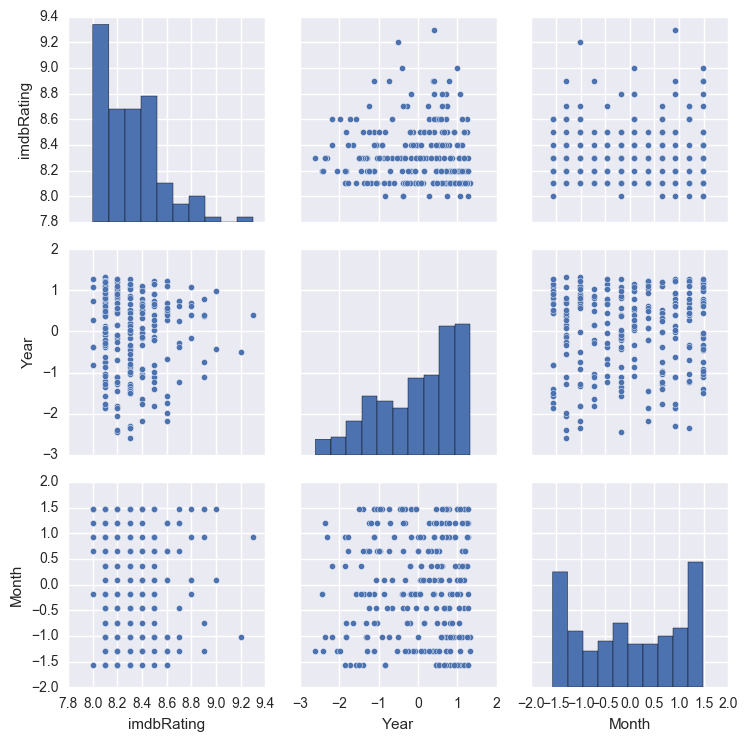

In [355]:
sns.pairplot(df3[["imdbRating", "Year", "Month"]]);

In [356]:
df3.to_csv("imdb_model.csv", encoding="utf-8")

# Model: Define training set

In [357]:
df4 = df3.copy()

In [358]:
df3["imdbRating"].describe()

count    250.000000
mean       8.311600
std        0.231603
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: imdbRating, dtype: float64

In [359]:
X = df4.copy()[num_cat_features]
y = df4.copy()["imdbRating"]

In [360]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=77)

# Model: Fit and evaluate model
Bonus: How is model at risk of overfitting?

## Regression
Trying to predict an actual rating

In [361]:
gs = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(random_state=1),
                                  {"n_estimators": np.arange(50,100,10)},
                                  cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [362]:
gs.best_params_

{'n_estimators': 90}

In [363]:
gbr = gs.best_estimator_

In [364]:
y_pred = gbr.predict(X_test)

In [365]:
check = pd.DataFrame([y_test, y_pred], index=["actual", "predicted"]).T

In [366]:
gbr.score(X_test, y_test)

0.43752653818349341

In [367]:
metrics.mean_squared_error(y_test, y_pred)

0.023772878366623368

In [368]:
check.head()

,actual,predicted
241,8.2,NaN
85,8.2,NaN
104,8.1,NaN
92,8.1,NaN
13,8.1,8.157351


Observations:
- Our model didn't do very well with the test set
- Seems like the random forest regressor overfit our training data and performed poorly on our test set

## Classification

In [369]:
df5 = df4.copy()

In [370]:
df5["rating_higher_8.5"] = df5["imdbRating"].map(lambda x: 1 if x >= 8.5 else 0)

In [371]:
X = df5[num_cat_features]
y = df5["rating_higher_8.5"]

In [372]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=77)

In [373]:
gs2 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(random_state=1),
                                  {"n_estimators": np.arange(50,100,10),
                                   "min_samples_split": np.arange(5,10,1), 
                                   "min_samples_leaf": np.arange(5,10,1)},
                                  cv=5)
gs2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90]), 'min_samples_split': array([5, 6, 7, 8, 9]), 'min_samples_leaf': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [374]:
gs2.best_params_

{'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 70}

In [375]:
gbc = gs2.best_estimator_

In [376]:
y_pred = gbc.predict(X_test)

In [377]:
gbc.score(X_test, y_test)

0.78666666666666663

Classification does much better than regression.

## Adding in text features

In [454]:
df6 = df4.copy()

In [455]:
vectorizer = feature_extraction.text.CountVectorizer(token_pattern=u'(?u)\w+.?\w?.? \w+')
actors_df = pd.DataFrame(vectorizer.fit_transform(df6["Actors"]).todense(), columns = vectorizer.get_feature_names())

In [456]:
top_10_actors = actors_df.sum().sort_values(ascending=False).head(10).index
top_10_actors = [i.replace(" ", "_") for i in top_10_actors]

In [457]:
top_10_actors

[u'robert_de_niro',
 u'harrison_ford',
 u'leonardo_dicaprio',
 u'clint_eastwood',
 u'tom_hanks',
 u'mark_hamill',
 u'james_stewart',
 u'christian_bale',
 u'matt_damon',
 u'joe_pesci']

In [458]:
for i in top_10_actors:
    df6["Actor_"+i.replace(" ", "_")] = actors_df.loc[:,i.replace("_", " ")]

In [459]:
df6.head()

,imdbRating,imdbID,Title,Writer,Actors,Director,Plot,Metascore,Year,Month,...,Actor_robert_de_niro,Actor_harrison_ford,Actor_leonardo_dicaprio,Actor_clint_eastwood,Actor_tom_hanks,Actor_mark_hamill,Actor_james_stewart,Actor_christian_bale,Actor_matt_damon,Actor_joe_pesci
0,8.5,tt2582802,Whiplash,Damien Chazelle,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,A promising young drummer enrolls at a cut-thr...,0.880238,1.237621,0.924913,...,0,0,0,0,0,0,0,0,0,0
1,8.7,tt0047478,Seven Samurai,"Akira Kurosawa (screenplay), Shinobu Hashimoto...","Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"A veteran samurai, who has fallen on hard time...",1.140018,-1.240595,1.201833,...,0,0,0,0,0,0,0,0,0,0
2,8.5,tt0082971,Raiders of the Lost Ark,"Lawrence Kasdan (screenplay), George Lucas (st...","Harrison Ford, Karen Allen, Paul Freeman, Rona...",Steven Spielberg,The year is 1936. An archeology professor name...,0.802304,-0.125398,-0.182767,...,0,1,0,0,0,0,0,0,0,0
3,8.2,tt0050212,The Bridge on the River Kwai,"Pierre Boulle (novel), Carl Foreman (screenpla...","William Holden, Alec Guinness, Jack Hawkins, S...",David Lean,After settling his differences with a Japanese...,-1.405824,-1.116684,1.478754,...,0,0,0,0,0,0,0,0,0,0
4,8.1,tt0848228,The Avengers,"Joss Whedon (screenplay), Zak Penn (story), Jo...","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Joss Whedon,"Nick Fury is the director of S.H.I.E.L.D., an ...",0.386656,1.155014,-0.459687,...,0,0,0,0,0,0,0,0,0,0


In [432]:
tfidf = feature_extraction.text.TfidfVectorizer(stop_words="english", ngram_range=(1,1), max_features=1000)

In [433]:
plot_df = pd.DataFrame(tfidf.fit_transform(df6["Plot"]).todense(), columns=tfidf.get_feature_names())

In [434]:
plot_df.head()

,000,15,30,abandoned,abducted,ability,able,abroad,accept,accident,...,worst,writer,writes,wrong,wwi,wwii,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.245541
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.133198,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [435]:
df6 = pd.concat([df6,plot_df], axis=1)

In [460]:
X = df6.iloc[:,7:]

### Regression

In [461]:
y = df6["imdbRating"]

In [462]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=77)

In [463]:
gs3 = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(random_state=1),
                                  {"n_estimators": np.arange(50,100,10)},
                                  cv=5)
gs3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [464]:
gs3.best_params_

{'n_estimators': 90}

In [465]:
gbr2 = gs3.best_estimator_

In [466]:
y_pred = gbr2.predict(X_test)

In [467]:
check = pd.DataFrame([y_test, y_pred], index=["actual", "predicted"]).T

In [468]:
gbr2.score(X_test, y_test)

0.44127180940856792

In [469]:
metrics.mean_squared_error(y_test, y_pred)

0.023614584894436838

Regression is still not performing well.

### Classification

In [470]:
df6["rating_higher_8.5"] = df6["imdbRating"].map(lambda x: 1 if x >= 8.5 else 0)
y = df6["rating_higher_8.5"]

In [471]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=77)

In [472]:
gs4 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(random_state=1),
                                  {"n_estimators": np.arange(50,100,10),
                                   "min_samples_split": np.arange(5,10,1), 
                                   "min_samples_leaf": np.arange(5,10,1)},
                                  cv=5)
gs4.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90]), 'min_samples_split': array([5, 6, 7, 8, 9]), 'min_samples_leaf': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [473]:
gs4.best_params_

{'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 70}

In [474]:
gbc2 = gs4.best_estimator_

In [475]:
y_pred = gbc2.predict(X_test)

In [476]:
gbc2.score(X_test, y_test)

0.78666666666666663

## Feature selection

In [479]:
select = feature_selection.RFECV(gbc2,cv=5)

In [488]:
select.fit(X_train, y_train)

RFECV(cv=5,
   estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=5, min_weight_fraction_leaf=0.0,
              n_estimators=70, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [489]:
select.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False], dtype=bool)

In [490]:
X_train = select.transform(X_train)

In [491]:
gbc2.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=5, min_weight_fraction_leaf=0.0,
              n_estimators=70, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)

In [492]:
gbc2.score(select.transform(X_test), y_test)

0.78666666666666663